In [1]:
# setup environment
!pip install kappamodules
!pip install torch_geometric

In [2]:
!pip uninstall torch -y
!pip uninstall torchaudio -y
!pip uninstall torchvision -y
# torch_cluster often doesnt support newest pytorch version which is by default installed in colab -> install older one
!pip install torch==2.3.0+cu121 torchvision==0.18.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html
# install torch_scatter
!pip install torch_scatter torch_cluster -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

Found existing installation: torch 2.3.0+cu121
Uninstalling torch-2.3.0+cu121:
  Successfully uninstalled torch-2.3.0+cu121
Found existing installation: torchvision 0.18.0+cu121
Uninstalling torchvision-0.18.0+cu121:
  Successfully uninstalled torchvision-0.18.0+cu121
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu121/torch-2.3.0%2Bcu121-cp310-cp310-linux_x86_64.whl (781.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.17 requires torchvision>=0.11, which is not installed.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.18.0%2Bcu121-cp310-cp310-linux_x86_64.whl (7.0 MB)
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html


In [3]:
# check successful setup
import torch
print(torch.__version__)
device = torch.device("cuda")
print(torch.cuda.get_device_name(device))
import torchvision
print(torchvision.__version__)
from torch_geometric.nn.pool import radius_graph
from torch_scatter import segment_csr

2.3.0+cu121
Tesla T4
0.18.0+cu121


In [4]:
# clone repo
!git clone https://github.com/BenediktAlkin/upt-minimal.git
%cd upt-minimal

fatal: destination path 'upt-minimal' already exists and is not an empty directory.
/content/upt-minimal


# 5 Pointcloud Autoencoder

Now that we know how the encoder works with sparse tensors, we will now also predict a sparse tensor.
To this end, we'll train UPT on `SparseCIFAR10` in an autoencoder setting.

<img width="60%" src="https://raw.githubusercontent.com/BenediktAlkin/upt-minimal/main/schematics/upt_sparse_autoencoder.svg">

For simplicity, we use a fixed number of output points, but this is not a requirement.
But it would need some more dataloading stuff to create the tensors for `torch_geometric.utils.unbatch`
which is a function that produces a sparse tensor from a padded dense tensor.

Again, lets initialize the dataset and visualize a sample:

In [5]:
# initialize CIFAR10
from upt.datasets.sparse_cifar10_autoencoder_dataset import SparseCIFAR10AutoencoderDataset
from torchvision.transforms import ToTensor
train_dataset = SparseCIFAR10AutoencoderDataset(
    root="./data",
    train=True,
    download=True,
    transform=ToTensor(),
    # use half of the inputs for training (32x32 pixels = 1024)
    num_inputs=512,
    # use 3/4th of the outputs for training (32x32 pixels = 1024)
    num_outputs=768,
)

Files already downloaded and verified


Files already downloaded and verified


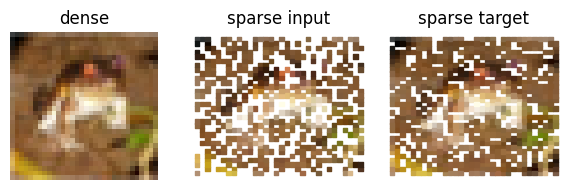

In [6]:
# now plotting is a bit trickier because we have a sparse tensor
# we'll make a scatter plot where each point is colored with the
# RGB value of the pixel
import matplotlib.pyplot as plt
import einops

# get dense sample
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
train_dataset_dense = CIFAR10(root="./data", train=True, download=True)
dense_sample = train_dataset_dense[0][0]
dense_sample = ToTensor()(dense_sample)
# get sparse sample
sample = train_dataset[0]
x_in, y_in = sample["input_pos"].unbind(1)
c_in = sample["input_feat"]
x_out, y_out = sample["output_pos"].unbind(1)
c_out = sample["target_feat"]

_, axes = plt.subplots(1, 3, figsize=(6, 2))
axes[0].imshow(einops.rearrange(dense_sample, "three height width -> height width three"))
axes[0].set_title("dense")
axes[0].set_axis_off()
axes[1].scatter(y_in, 31 - x_in, c=c_in, marker="s", s=10)
axes[1].set_title("sparse input")
axes[1].set_axis_off()
axes[2].scatter(y_out, 31 - x_out, c=c_out, marker="s", s=10)
axes[2].set_title("sparse target")
axes[2].set_axis_off()
plt.tight_layout()
plt.show()

Lets see how a forward pass looks like for a single sample (so we don't need a collator yet)

In [7]:
from upt.models.encoder_supernodes import EncoderSupernodes

encoder = EncoderSupernodes(
    # CIFAR has 3 channels (RGB)
    input_dim=3,
    # CIFAR is an image dataset -> 2D
    ndim=2,
    # there are 32x32 pixels so positions are in [0, 31], to have roughly the same input as a ViT
    # with patch_size=4, we'll use radius slighly larger than 2
    radius=5,
    # if we split a 32x32 image into 8x8 gridpoints, each point would cover 4x4 pixels, i.e. 16 pixels (=nodes)
    # since we sample supernodes randomly and use a larger radius, it can happen that more than 16 nodes
    # are in the radius of a supernode, so we'll use at maximum 32 connections to each supernode
    max_degree=32,
    # dimension for the supernode pooling -> use same as ViT-T latent dim
    gnn_dim=192,
    # ViT-T latent dimension
    enc_dim=192,
    enc_num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    enc_depth=4,
    # the perceiver is optional, it changes the size of the latent space to NUM_LATENT_TOKENS tokens
    # perc_dim=dim,
    # perc_num_heads=num_heads,
    # num_latent_tokens=32,
)

# for now, we only encode 1 sample, so we need to generate some supernode indices
# later the collator will take care of this
sample = train_dataset[0]
# select 64 random pixels as supernodes
supernode_idxs = torch.randperm(len(sample["input_feat"]))[:64]
# and we need a batch_idx tensor
batch_idx = torch.zeros(len(sample["input_feat"]), dtype=torch.long)
encoded_pointcloud = encoder(
    input_feat=sample["input_feat"],
    input_pos=sample["input_pos"],
    supernode_idxs=supernode_idxs,
    batch_idx=batch_idx,
)
print(f"encoded_pointcloud.shape: {encoded_pointcloud.shape}")

encoded_pointcloud.shape: torch.Size([1, 64, 192])


In this setting, we dont really need an approximator, but we'll keep it for consistency.

In [8]:
from upt.models.approximator import Approximator

approximator = Approximator(
    # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
    input_dim=192,
    # as in ViT-T
    dim=192,
    num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    depth=4,
)

approximator_output = approximator(encoded_pointcloud)
print(f"approximator_output.shape: {approximator_output.shape}")

approximator_output.shape: torch.Size([1, 64, 192])


The decoder now queries the latent space with the corresponding output positions:

In [9]:
from upt.models.decoder_perceiver import DecoderPerceiver

decoder = DecoderPerceiver(
    # tell the decoder the dimension of the input (dim of approximator)
    input_dim=192,
    # 3 channels for RGB
    output_dim=3,
    # images have 2D coordinates
    ndim=2,
    # as in ViT-T
    dim=192,
    num_heads=3,
    # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
    depth=4,
    # we assume an unpadded dense tensor (fixed num_outputs) -> conver to sparse tensor
    unbatch_mode="dense_to_sparse_unpadded",
)
prediction = decoder(approximator_output, output_pos=sample["output_pos"].unsqueeze(0))
print(f"prediction.shape: {prediction.shape}")

prediction.shape: torch.Size([768, 3])


In [10]:
# the predictions have the same shape as our reconstruction target -> easy loss calculation
print(f"target_feat.shape: {sample['target_feat'].shape}")

target_feat.shape: torch.Size([768, 3])


# Train a model
Now we can put it all together and train UPT in as an autoencoder.

In [12]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm

from upt.models.approximator import Approximator
from upt.models.decoder_perceiver import DecoderPerceiver
from upt.models.encoder_supernodes import EncoderSupernodes
from upt.models.upt_sparseimage_autoencoder import UPTSparseImageAutoencoder
from upt.datasets.sparse_cifar10_autoencoder_dataset import SparseCIFAR10AutoencoderDataset
from upt.collators.sparseimage_autoencoder_collator import SparseImageAutoencoderCollator



# initialize dataset
transform = ToTensor()
train_dataset = SparseCIFAR10AutoencoderDataset(
    root="./data",
    train=True,
    download=True,
    transform=transform,
    # use half of the inputs for training (32x32 pixels = 1024)
    num_inputs=512,
    # use 3/4th of the outputs for training (32x32 pixels = 1024)
    num_outputs=768,
)
test_dataset = SparseCIFAR10AutoencoderDataset(
    root="./data",
    train=False,
    download=True,
    transform=transform,
    # use all inputs/outputs for evaluation (32x32 pixels = 1024)
    num_inputs=1024,
    num_outputs=1024,
)

# hyperparameters
dim = 192  # ~6M parameter model
num_heads = 3
epochs = 10
batch_size = 64

# initialize model
model = UPTSparseImageAutoencoder(
    encoder=EncoderSupernodes(
        # CIFAR has 3 channels (RGB)
        input_dim=3,
        # CIFAR is an image dataset -> 2D
        ndim=2,
        # there are 32x32 pixels so positions are in [0, 31], to have roughly the same input as a ViT
        # with patch_size=4, we'll use radius slighly larger than 4
        radius=4,
        # if we split a 32x32 image into 8x8 gridpoints, each point would cover 4x4 pixels, i.e. 16 pixels (=nodes)
        # since we sample supernodes randomly and use a larger radius, it can happen that more than 16 nodes
        # are in the radius of a supernode, so we'll use at maximum 32 connections to each supernode
        max_degree=32,
        # dimension for the supernode pooling -> use same as ViT-T latent dim
        gnn_dim=dim,
        # ViT-T latent dimension
        enc_dim=dim,
        enc_num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        enc_depth=4,
        # the perceiver is optional, it changes the size of the latent space to NUM_LATENT_TOKENS tokens
        # perc_dim=dim,
        # perc_num_heads=num_heads,
        # num_latent_tokens=32,
    ),
    approximator=Approximator(
        # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
        input_dim=dim,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=4,
    ),
    decoder=DecoderPerceiver(
        # tell the decoder the dimension of the input (dim of approximator)
        input_dim=dim,
        # 3 channels for RGB
        output_dim=3,
        # images have 2D coordinates
        ndim=2,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=4,
    ),
)
model = model.to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

# setup dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=SparseImageAutoencoderCollator(num_supernodes=64, deterministic=False),
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    collate_fn=SparseImageAutoencoderCollator(num_supernodes=64, deterministic=True),
)

# initialize optimizer and learning rate schedule (linear warmup for first 10% -> linear decay)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
total_updates = len(train_dataloader) * epochs
warmup_updates = int(total_updates * 0.1)
lrs = torch.concat(
    [
        # linear warmup
        torch.linspace(0, optim.defaults["lr"], warmup_updates),
        # linear decay
        torch.linspace(optim.defaults["lr"], 0, total_updates - warmup_updates),
    ],
)

# train model
update = 0
pbar = tqdm(total=total_updates)
pbar.update(0)
pbar.set_description("train_loss: ????? train_accuracy: ????% test_accuracy: ????%")
test_accuracy = 0.0
train_losses = []
test_losses = []
loss = None
test_loss = None
for _ in range(epochs):
    # train for an epoch
    for batch in train_dataloader:
        # schedule learning rate
        for param_group in optim.param_groups:
            param_group["lr"] = lrs[update]

        # forward pass
        y_hat = model(
            input_feat=batch["input_feat"].to(device),
            input_pos=batch["input_pos"].to(device),
            supernode_idxs=batch["supernode_idxs"].to(device),
            batch_idx=batch["batch_idx"].to(device),
            output_pos=batch["output_pos"].to(device),
        )
        y = batch["target_feat"].to(device)
        assert y_hat.shape == y.shape
        loss = F.mse_loss(y_hat, y)

        # backward pass
        loss.backward()

        # update step
        optim.step()
        optim.zero_grad()

        # status update
        update += 1
        pbar.update()
        if test_loss is None:
            pbar.set_description(f"train_loss: {loss.item():.4f}")
        else:
            pbar.set_description(
                f"train_loss: {loss.item():.4f} "
                f"test_loss: {test_loss:.4f} "
            )
        train_losses.append(loss.item())

    # evaluate
    # test_loss = 0.
    # for batch in test_dataloader:
    #     with torch.no_grad():
    #         y_hat = model(
    #             input_feat=batch["input_feat"].to(device),
    #             input_pos=batch["input_pos"].to(device),
    #             supernode_idxs=batch["supernode_idxs"].to(device),
    #             batch_idx=batch["batch_idx"].to(device),
    #             output_pos=batch["output_pos"].to(device),
    #         )
    #     y = batch["target_feat"].to(device)
    #     test_loss += (F.mse_loss(y_hat, y, reduction="sum") / y.numel()).item()
    # test_loss /= len(test_dataloader)
    # test_losses.append(test_loss)
    # pbar.set_description(
    #     f"train_loss: {loss.item():.4f} "
    #     f"test_loss: {test_loss:.4f} "
    # )
pbar.close()

Files already downloaded and verified
Files already downloaded and verified
parameters: 98.6M


train_loss: 0.0649:   1%|          | 96/7810 [02:54<3:51:52,  1.80s/it]

KeyboardInterrupt: 

Lets plot the learning curves

In [ ]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(range(len(train_losses)), train_losses)
axes[0].set_xlabel("Updates")
axes[0].set_ylabel("Train Loss")
axes[0].set_title("Train Loss")
axes[0].grid(True)
axes[1].plot(range(len(test_losses)), test_losses)
axes[1].set_xlabel("Updates")
axes[1].set_ylabel("Test Loss")
axes[1].set_title("Test Loss")
axes[1].grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# get test sample
vis_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=1,
    collate_fn=SparseImageAutoencoderCollator(num_supernodes=64, deterministic=True),
)
vis_batch = next(iter(vis_dataloader))

In [ ]:
# make predictions
with torch.no_grad():
    y_hat = model(
        input_feat=vis_batch["input_feat"].to(device),
        input_pos=vis_batch["input_pos"].to(device),
        supernode_idxs=vis_batch["supernode_idxs"].to(device),
        batch_idx=vis_batch["batch_idx"].to(device),
        output_pos=vis_batch["output_pos"].to(device),
    )

In [ ]:
# plot sparse
sample = vis_batch
x_out, y_out = sample["output_pos"][0].unbind(1)
c_pred = y_hat.cpu().clamp(0, 1)
c_out = sample["target_feat"]

_, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].scatter(y_out, 31 - x_out, c=c_out, marker="s", s=10)
axes[0].set_title("target")
axes[0].set_axis_off()
axes[1].scatter(y_out, 31 - x_out, c=c_pred, marker="s", s=10)
axes[1].set_title("pred")
axes[1].set_axis_off()
plt.tight_layout()
plt.show()